<a href="https://colab.research.google.com/github/avionerman/computational_and_statistical/blob/novissimus/novissimus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries/packages

In [150]:
#!pip install cupy-cuda12x
import os
import time
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp

# scikit lib (CPU) for data loading and metrics only-
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import seaborn as sns

# cuML alternative of sklearn lib (GPU) for models execution & pca
from cuml.svm import LinearSVC, SVC
from cuml.neighbors import KNeighborsClassifier
from cuml.decomposition import PCA as cuPCA
from cuml.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid


# Configuration

In [151]:
DATASET_NAME = "CIFAR10"

USE_PCA = True
PCA_VARIANCE = 0.90
RANDOM_STATE = 42
SHOW_EXAMPLES = True

# Data loading

In [152]:
def load_data(dataset_name):
    """
    Returns: (x_train, y_train), (x_test, y_test), class_names
    """

    print(f"Loading {dataset_name} ...")

    if dataset_name == "CIFAR10":
        from tensorflow.keras.datasets import cifar10
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()

        # Flatten labels to 1D array
        y_train = y_train.flatten()
        y_test = y_test.flatten()

        class_names = [
            "airplane", "automobile", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"
        ]

    elif dataset_name == "SVHN":
        def get_svhn_split(split, data_dir="./data"):
            os.makedirs(data_dir, exist_ok=True)
            urls = {
                "train": "http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
                "test":  "http://ufldl.stanford.edu/housenumbers/test_32x32.mat",
            }
            filepath = os.path.join(data_dir, urls[split].split("/")[-1])

            if not os.path.exists(filepath):
                print(f"Downloading SVHN {split} set...")
                urllib.request.urlretrieve(urls[split], filepath)

            data = loadmat(filepath)
            X = np.transpose(data["X"], (3, 0, 1, 2)) # (N, 32, 32, 3)
            y = data["y"].flatten()
            y[y == 10] = 0 # Map digit '0' (labeled as 10) to 0
            return X, y

        x_train, y_train = get_svhn_split("train")
        x_test, y_test = get_svhn_split("test")
        class_names = [str(i) for i in range(10)]

    else:
        raise ValueError("Invalid DATASET_NAME. Choose 'CIFAR10' or 'SVHN'.")

    print(f"Dataset Loaded. Train: {x_train.shape}, Test: {x_test.shape}")
    return (x_train, y_train), (x_test, y_test), class_names

# Preprocessing

In [153]:
def preprocess_pipeline(x_train, x_test, use_pca=True, variance=0.90):
    # 1. Flatten and Normalize (Safe on CPU first)
    x_train_flat = x_train.reshape(len(x_train), -1).astype("float32") / 255.0
    x_test_flat  = x_test.reshape(len(x_test), -1).astype("float32") / 255.0

    # 2. Standardize (CPU - sklearn is reliable here)
    print("Standardizing data (CPU)...")
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_flat)
    x_test_scaled  = scaler.transform(x_test_flat)

    # 3. PCA (GPU)
    if use_pca:
        print(f"PCA enabled (Variance={variance})...")
        # Move to GPU
        x_tr_gpu = cp.asarray(x_train_scaled)
        x_te_gpu = cp.asarray(x_test_scaled)

        # FIX: Explicitly set n_components to min(samples, features) to silence warning
        n_samples, n_features = x_tr_gpu.shape
        n_components_full = min(n_samples, n_features)

        # Fit full PCA to measure variance
        pca_full = cuPCA(n_components=n_components_full)
        pca_full.fit(x_tr_gpu)
        explained_var = cp.cumsum(pca_full.explained_variance_ratio_)

        # Calculate exact components needed for variance threshold
        var_thresh = cp.array([variance])
        n_components = int(cp.searchsorted(explained_var, var_thresh)[0]) + 1

        print(f"Components needed: {n_components}")

        # Refit with exact components
        pca_final = cuPCA(n_components=n_components)
        x_train_final = pca_final.fit_transform(x_tr_gpu)
        x_test_final = pca_final.transform(x_te_gpu)

        return x_train_final, x_test_final
    else:
        print("PCA disabled. Moving raw standardized data to GPU...")
        return cp.asarray(x_train_scaled), cp.asarray(x_test_scaled)

# Model Engines | LinearSVC, SVC(poly, rbf)

In [154]:
def run_model(model_type, x_train, y_train, x_test, y_test, classes, params=None):
    # Local imports for stability
    import time
    import numpy as np
    import cupy as cp
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.neighbors import NearestCentroid
    from cuml.svm import LinearSVC, SVC
    from cuml.neighbors import KNeighborsClassifier
    from sklearn.model_selection import ParameterGrid, StratifiedKFold

    if params is None: params = {}
    print(f"\n--- Running {model_type} ---")
    start_time = time.time()

    # Data Setup
    y_train_cpu = cp.asnumpy(y_train) if hasattr(y_train, 'device') else y_train
    y_train_gpu = cp.asarray(y_train)
    y_test_cpu  = cp.asnumpy(y_test)  if hasattr(y_test, 'device') else y_test

    x_train_gpu = cp.asarray(x_train) if not hasattr(x_train, 'device') else x_train
    x_test_gpu  = cp.asarray(x_test)  if not hasattr(x_test, 'device') else x_test

    if model_type == "NCC":
        base_clf = NearestCentroid()
        base_clf.fit(cp.asnumpy(x_train_gpu), y_train_cpu)
        best_model = base_clf
        best_params = "Default"
        predictions = best_model.predict(cp.asnumpy(x_test_gpu))
        y_train_pred = best_model.predict(cp.asnumpy(x_train_gpu))

    else:
        if model_type == "LinearSVC":
            ModelClass = LinearSVC
            grid_params = params if params else {"C": [0.1, 1, 10]}
        elif model_type == "RBF_SVM":
            ModelClass = lambda **k: SVC(kernel="rbf", **k)
            grid_params = params if params else {"C": [1, 10], "gamma": ["scale"]}
        elif model_type == "Poly_SVM":
            ModelClass = lambda **k: SVC(kernel="poly", **k)
            grid_params = params if params else {"C": [1], "degree": [3]}
        elif model_type == "KNN":
            ModelClass = KNeighborsClassifier
            grid_params = params if params else {"n_neighbors": [5, 11]}
        else:
            raise ValueError(f"Unknown model: {model_type}")

        # Robust Grid Search
        param_keys = [k for k, v in grid_params.items() if isinstance(v, list)]

        if not param_keys:
            best_model = ModelClass(**grid_params)
            best_model.fit(x_train_gpu, y_train_gpu)
            best_params = grid_params
        else:
            best_score = -1
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            param_grid = list(ParameterGrid(grid_params))

            print(f"Grid Search {len(param_grid)} configs...")

            for p in param_grid:
                scores = []
                for train_idx, val_idx in skf.split(y_train_cpu, y_train_cpu):
                    clf = ModelClass(**p)
                    clf.fit(x_train_gpu[train_idx], y_train_gpu[train_idx])
                    preds = clf.predict(x_train_gpu[val_idx])
                    scores.append(accuracy_score(cp.asnumpy(y_train_gpu[val_idx]), cp.asnumpy(preds)))

                if np.mean(scores) > best_score:
                    best_score = np.mean(scores)
                    best_params = p

            best_model = ModelClass(**best_params)
            best_model.fit(x_train_gpu, y_train_gpu)

        y_train_pred_gpu = best_model.predict(x_train_gpu)
        y_train_pred = cp.asnumpy(y_train_pred_gpu)
        y_test_pred_gpu = best_model.predict(x_test_gpu)
        predictions = cp.asnumpy(y_test_pred_gpu)

    elapsed = time.time() - start_time

    # Calculate Metrics
    train_acc = accuracy_score(y_train_cpu, y_train_pred)
    test_acc  = accuracy_score(y_test_cpu, predictions)
    precision = precision_score(y_test_cpu, predictions, average='macro', zero_division=0)
    recall    = recall_score(y_test_cpu, predictions, average='macro', zero_division=0)
    f1        = f1_score(y_test_cpu, predictions, average='macro', zero_division=0)

    # UPDATED PRINT STATEMENT: Shows all metrics immediately
    print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | "
          f"Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | "
          f"Time: {elapsed:.2f}s | Params: {best_params}")

    # Plot Confusion Matrix
    plot_confusion_matrix(y_test_cpu, predictions, classes, model_type)

    return {
        "model": model_type,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "time": elapsed,
        "params": best_params,
        "predictions": predictions
    }

# Visualize successful/failed images predictions per model

In [155]:
def visualize(x_raw, y_true, y_pred, classes, title):
    """
    Visualization helper that plots 5 correct and 5 incorrect examples.
    Renamed from 'visualize_results' to match the main() call.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    correct_idxs = np.where(y_true == y_pred)[0]
    incorrect_idxs = np.where(y_true != y_pred)[0]

    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{title} - Sample Predictions", fontweight='bold', fontsize=14)

    # Plot up to 5 Correct
    for i in range(min(5, len(correct_idxs))):
        idx = correct_idxs[i]
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_raw[idx])
        plt.axis('off')
        if i == 0: plt.title("CORRECT", color='green', fontweight='bold')

    # Plot up to 5 Incorrect
    for i in range(min(5, len(incorrect_idxs))):
        idx = incorrect_idxs[i]
        plt.subplot(2, 5, i + 6)
        plt.imshow(x_raw[idx])
        plt.axis('off')

        # Show True vs Pred labels
        true_label = classes[y_true[idx]]
        pred_label = classes[y_pred[idx]]
        plt.text(0, 38, f"T: {true_label}\nP: {pred_label}", fontsize=9, color='red')

        if i == 0: plt.title("INCORRECT", color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Confusion matrix

In [156]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.title(f"{title} - Confusion Matrix", fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize models' comparison diagram

In [157]:
def plot_model_comparison(results_df):
    """
    Plots a line chart comparing all models across multiple metrics.
    """
    import matplotlib.pyplot as plt

    # Define the metrics to plot
    metrics = ['test_acc', 'precision', 'recall', 'f1_score']

    plt.figure(figsize=(12, 6))

    # Plot a line for each model
    for i, row in results_df.iterrows():
        # Get the values for the metrics
        y_values = row[metrics].values

        # Plot line
        plt.plot(metrics, y_values, marker='o', linewidth=2, label=row['model'])

        # Add labels to the points for clarity
        for x, y in zip(metrics, y_values):
            plt.text(x, y + 0.01, f"{y:.2f}", fontsize=8, ha='center')

    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.ylabel('Score (0-1)', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Models")
    plt.tight_layout()
    plt.show()

# Main execution body

Loading CIFAR10 ...
Dataset Loaded. Train: (50000, 32, 32, 3), Test: (10000, 32, 32, 3)
Standardizing data (CPU)...
PCA enabled (Variance=0.9)...
Components needed: 103

--- Running LinearSVC ---
Grid Search 2 configs...
Train Acc: 0.3981 | Test Acc: 0.3967 | Prec: 0.3879 | Rec: 0.3967 | F1: 0.3833 | Time: 1.48s | Params: {'C': 0.1}


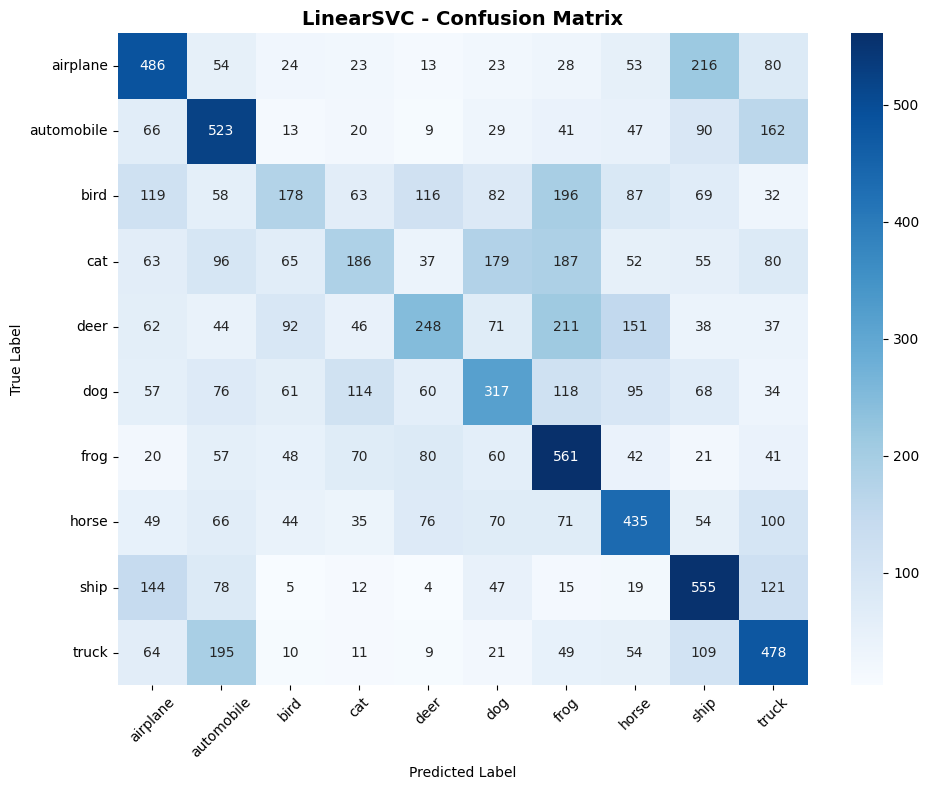

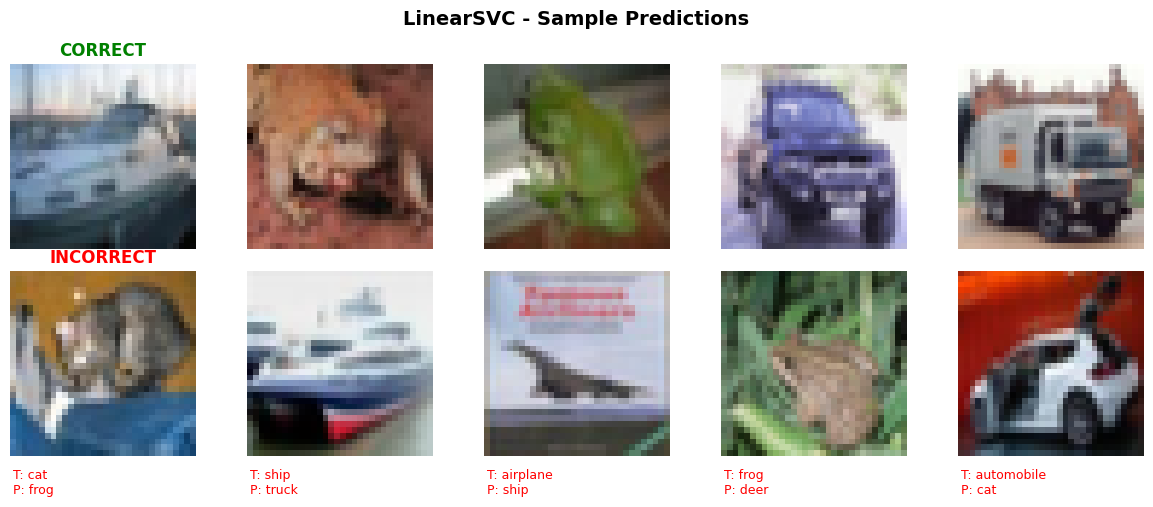


--- Running RBF_SVM ---
Grid Search 2 configs...
Train Acc: 0.9355 | Test Acc: 0.5670 | Prec: 0.5669 | Rec: 0.5670 | F1: 0.5667 | Time: 46.34s | Params: {'C': 10, 'gamma': 'scale'}


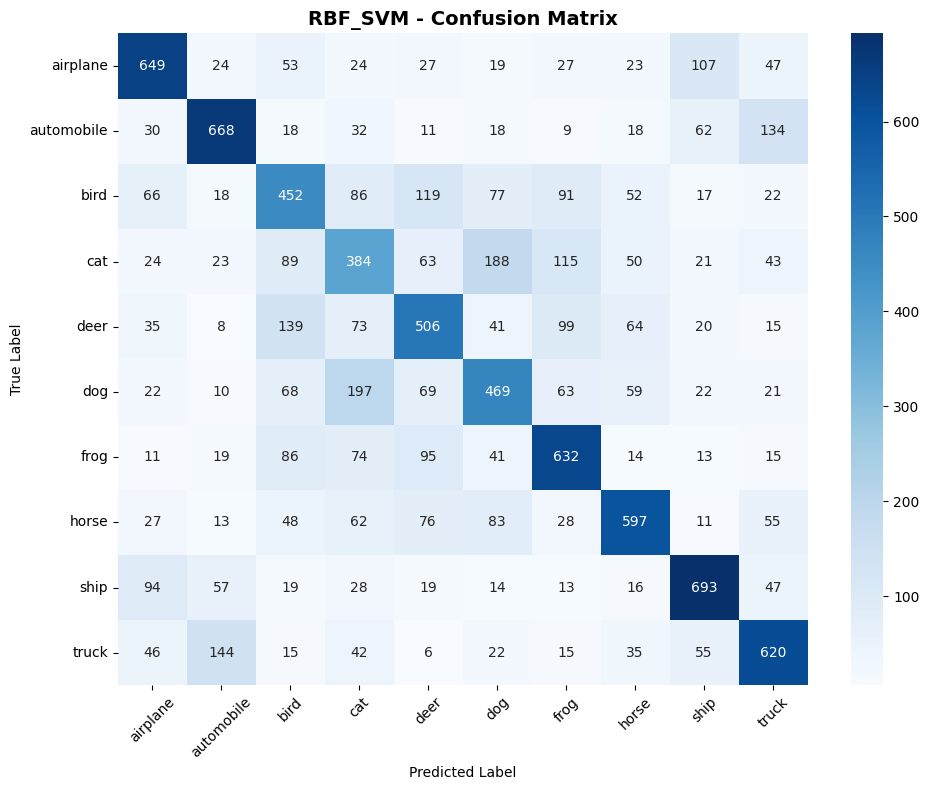

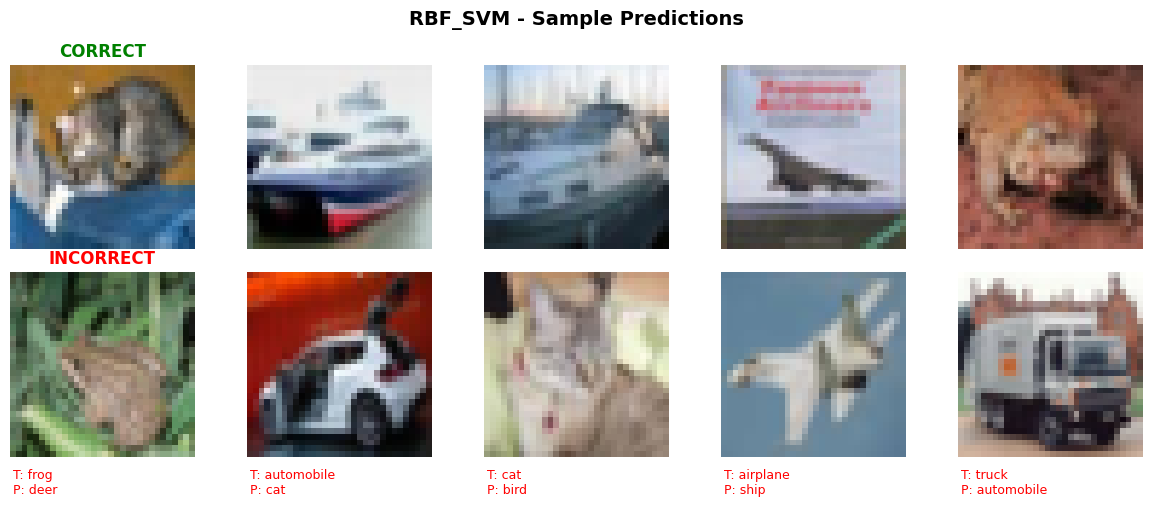


--- Running Poly_SVM ---
Grid Search 1 configs...
Train Acc: 0.6515 | Test Acc: 0.4714 | Prec: 0.5030 | Rec: 0.4714 | F1: 0.4780 | Time: 44.76s | Params: {'C': 1, 'degree': 3}


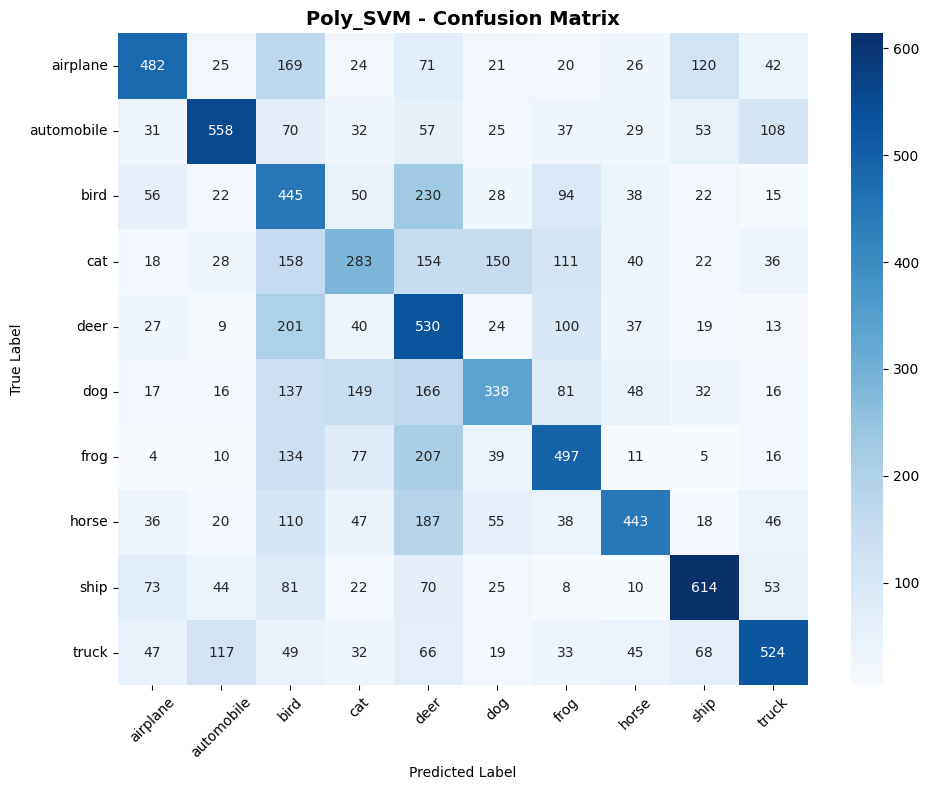


--- Running KNN ---
Grid Search 2 configs...
Train Acc: 0.4885 | Test Acc: 0.3842 | Prec: 0.4653 | Rec: 0.3842 | F1: 0.3781 | Time: 0.54s | Params: {'n_neighbors': 10}


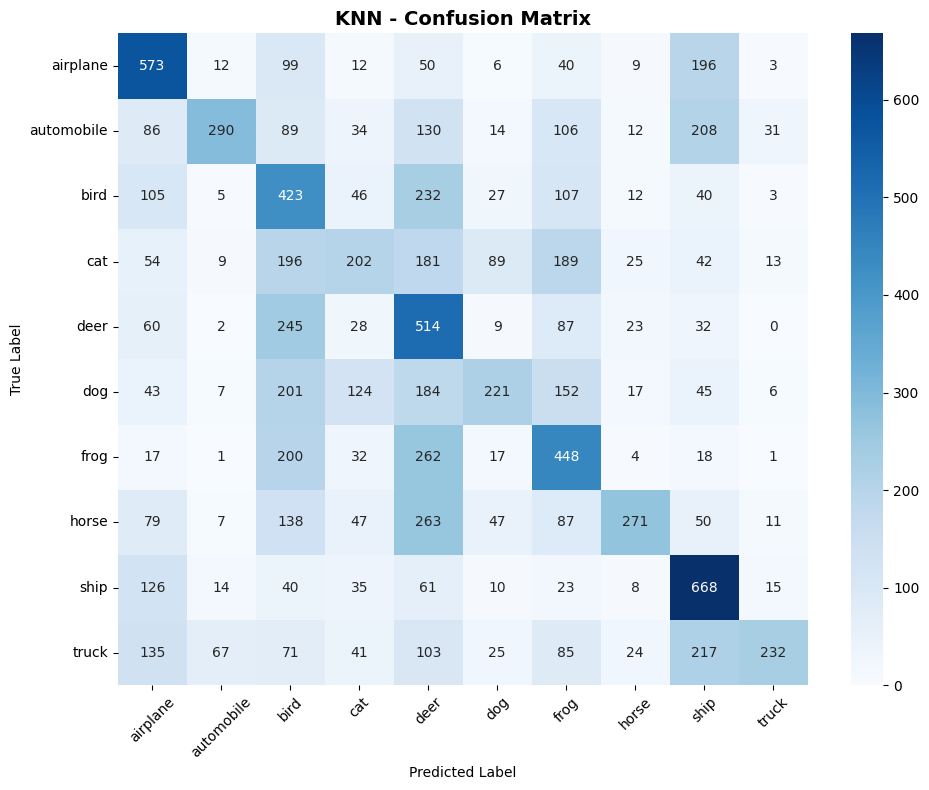


--- Running NCC ---
Train Acc: 0.2712 | Test Acc: 0.2807 | Prec: 0.2927 | Rec: 0.2807 | F1: 0.2589 | Time: 0.09s | Params: Default


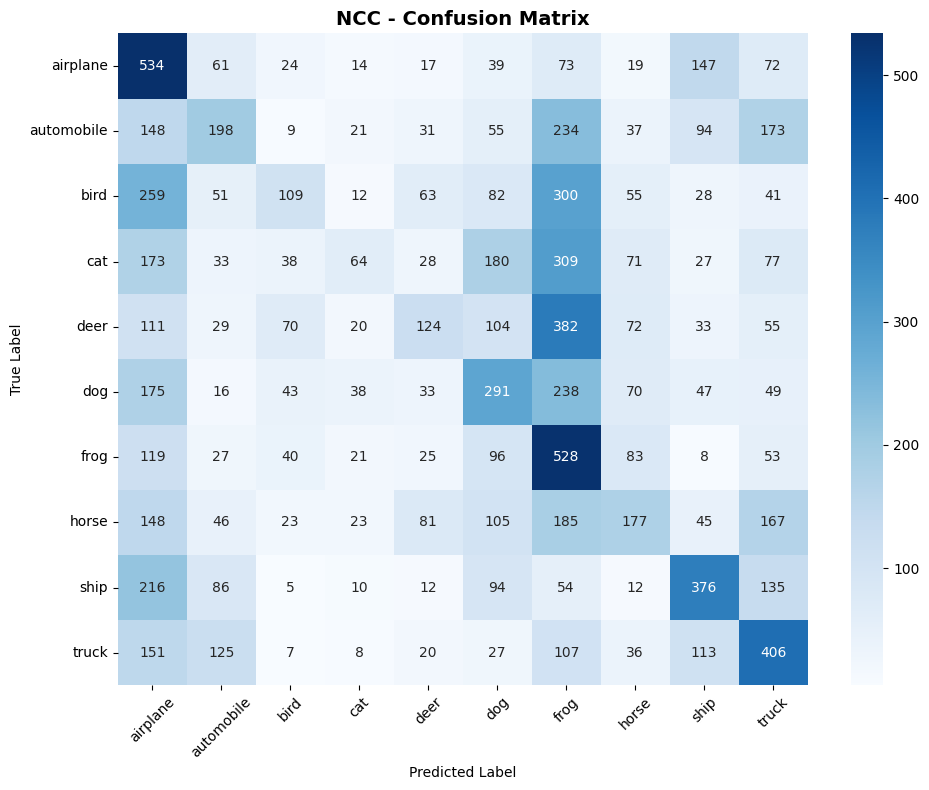


FINAL METRICS SUMMARY (CIFAR10)
    model  train_acc  test_acc  f1_score  precision  recall    time                      params
LinearSVC     0.3981    0.3967    0.3833     0.3879  0.3967  1.4788                  {'C': 0.1}
  RBF_SVM     0.9355    0.5670    0.5667     0.5669  0.5670 46.3442 {'C': 10, 'gamma': 'scale'}
 Poly_SVM     0.6515    0.4714    0.4780     0.5030  0.4714 44.7618       {'C': 1, 'degree': 3}
      KNN     0.4885    0.3842    0.3781     0.4653  0.3842  0.5358         {'n_neighbors': 10}
      NCC     0.2712    0.2807    0.2589     0.2927  0.2807  0.0859                     Default

Generating Model Comparison Chart...


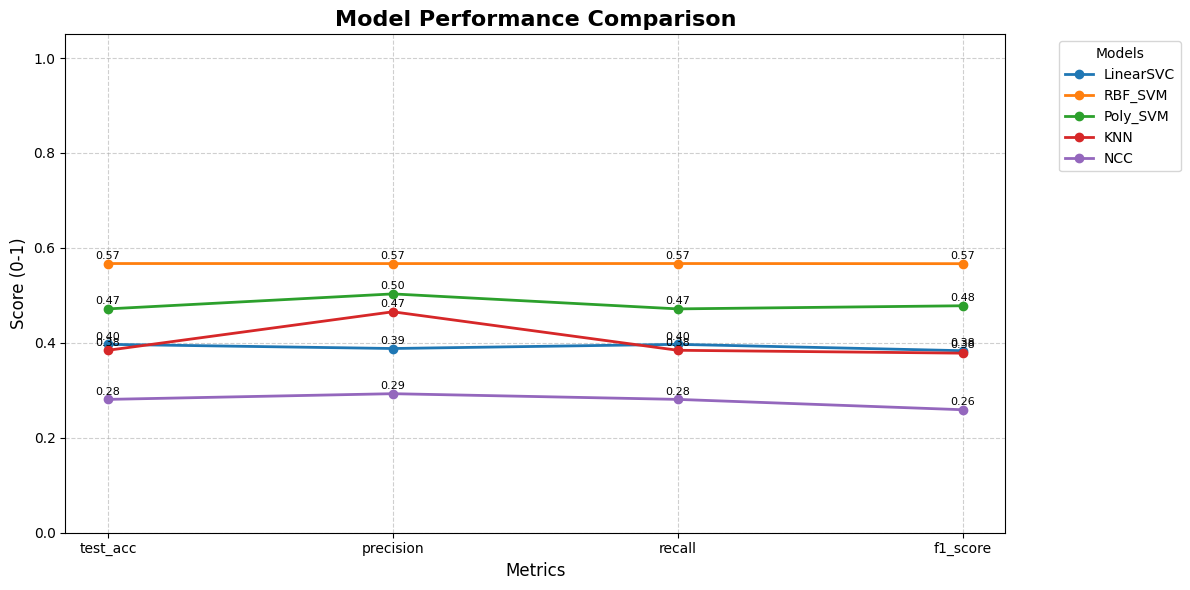

In [158]:
def main():
    # 1. Load Data (Numpy)
    (x_tr_raw, y_tr), (x_te_raw, y_te), classes = load_data(DATASET_NAME)

    # 2. Preprocess (Returns CuPy GPU Arrays)
    x_tr_gpu, x_te_gpu = preprocess_pipeline(x_tr_raw, x_te_raw, USE_PCA, PCA_VARIANCE)

    # 3. Define Models
    results = []
    models = [
        ("LinearSVC", {"C": [0.1, 1]}),
        ("RBF_SVM",   {"C": [1, 10], "gamma": ["scale"]}),
        ("Poly_SVM",  {"C": [1], "degree": [3]}),
        ("KNN",       {"n_neighbors": [5, 10]}),
        ("NCC",       {})
    ]

    # 4. Run Loop
    for name, params in models:
        # Pass 'classes' to run_model so charts work
        res = run_model(name, x_tr_gpu, y_tr, x_te_gpu, y_te, classes, params)
        results.append(res)

        # Visualize images for SVMs
        if SHOW_EXAMPLES and name in ["LinearSVC", "RBF_SVM"]:
            visualize(x_te_raw, y_te, res["predictions"], classes, name)

    # 5. Final Summary
    print("\n" + "="*80)
    print(f"FINAL METRICS SUMMARY ({DATASET_NAME})")
    print("="*80)

    df = pd.DataFrame(results)

    # Select columns to display
    summary_cols = [
        "model",
        "train_acc",
        "test_acc",
        "f1_score",
        "precision",
        "recall",
        "time",
        "params"
    ]

    # Create final dataframe and print
    final_df = df[summary_cols].round(4)
    print(final_df.to_string(index=False))

    # --- NEW: Call the Line Chart Visualization ---
    print("\nGenerating Model Comparison Chart...")
    plot_model_comparison(final_df)

if __name__ == "__main__":
    main()